In [92]:
import pandas as pd
import numpy as np
df = pd.read_csv("arima_data.csv", names = ["day", "price"])

In [93]:
df.head()

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190
3,2013-04-01,5783
4,2013-05-01,6298


In [94]:
df["price"].mean()

6689.733333333334

In [95]:
df["day"] = pd.to_datetime(df["day"], format = "%Y-%m-%d")

In [96]:
df = df.set_index("day")

In [97]:
# df[(df.index > "2013-01-01")& (df.index < "2015-01-01")]

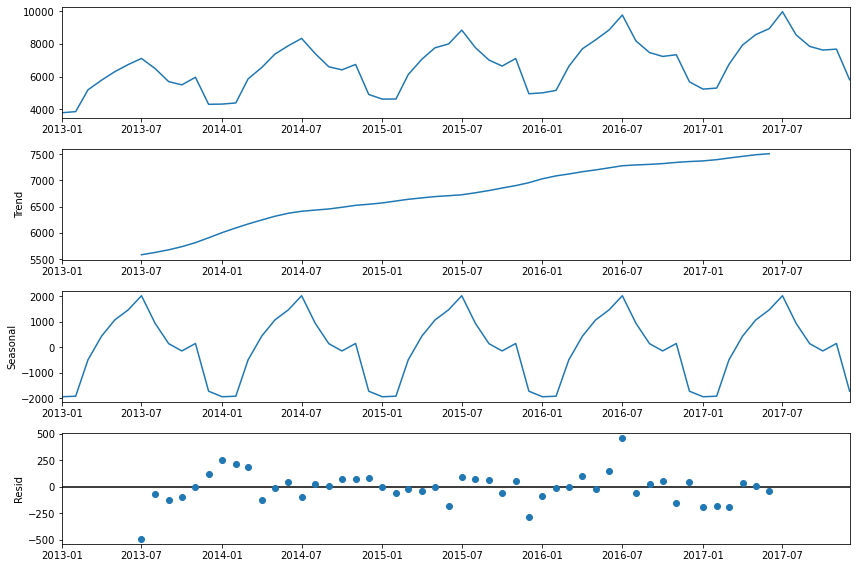

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

ts = df
result = seasonal_decompose(ts, model = "additive")

# https://financedata.github.io/posts/faq_matplotlib_default_chart_size.html : rc params 사용

plt.rcParams["figure.figsize"] = [12,8]
# plt.figure(figsize = (12,8))
result.plot()
plt.show()

In [99]:
# 계절성과 트랜드가 있다는걸 확인했으면 그다음에 정상성과 잔차를 확인한후에
# ARIMA 모델을 사용할수 있음
# ARIMA 모델을 사용하는 이유는 시간을 가지고 종속변수를 예측하기 위해

### 정상성 검정

In [100]:
# 정상성을 띄지 않는다면 정상성을 갖춘 데이터로 변환시킬 필요가 있음
# 정상성은 추세와 계절성을 갖지않는 진동하는 데이터이다

In [101]:
import pandas as pd

df = pd.read_csv("arima_data.csv", names = ["day","price"])

In [102]:
df["day"] = pd.to_datetime(df["day"], format = "%Y-%m-%d")

In [103]:
df.set_index("day", inplace = True)

In [104]:
train_len = int(df.shape[0] * 0.8)
train_set = df[:train_len]
test_set = df.drop(train_set.index, axis = 0)

In [105]:
# 정상성 확인
# 귀무가설 : 데이터가 정상성을 갖지 않는다(변동이 있다)
# 대립가설 : 데이터가 정상성을 갖는다

from statsmodels.tsa.stattools import adfuller

adf = adfuller(train_set, regression = "ct") #상수항을 갖는다는건 시계열 변수의 평균값이 0이 아닌지

print("ADF -statistic :", adf[0])
print("P_value:", adf[1])

ADF -statistic : -1.9997199341327108
P_value: 0.6015863303794554


In [106]:
# 정상성을 갖지 않으므로 차분 후 검정 재실시
# 차분이란 ? 비정상성을 정상성으로 만들기 위해, 관측값들의 차이를 계산하는것

### 시계열 데이터 정상성 만족시키기

<AxesSubplot:xlabel='day'>

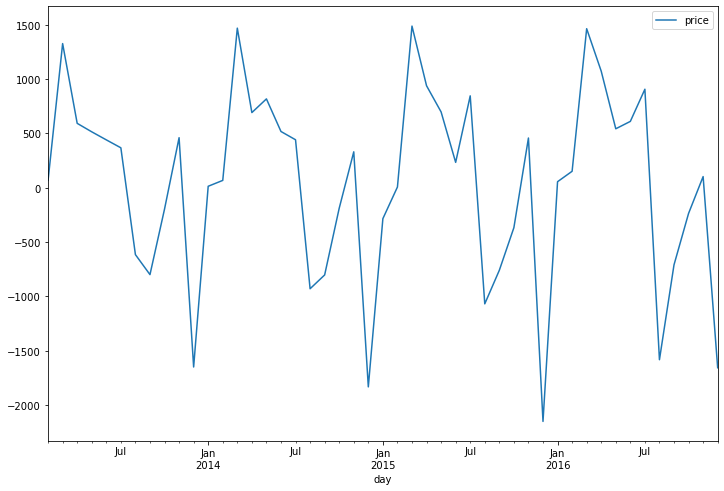

In [107]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_data = train_set.diff(1)
diff_data = diff_data.dropna()

diff_data.plot()

In [108]:
# 차분한 데이터로 다시 한번 더 검정
from statsmodels.tsa.stattools import adfuller
adf = adfuller(diff_data)
print("ADF Statistic : {}".format(adf[0]))
print("p-value : {}".format(adf[1]))

ADF Statistic : -12.094547576926429
p-value : 2.085160639961008e-22


### ARIMA(p,d,q)의 파라미터 정하기

C:\Users\gg787\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


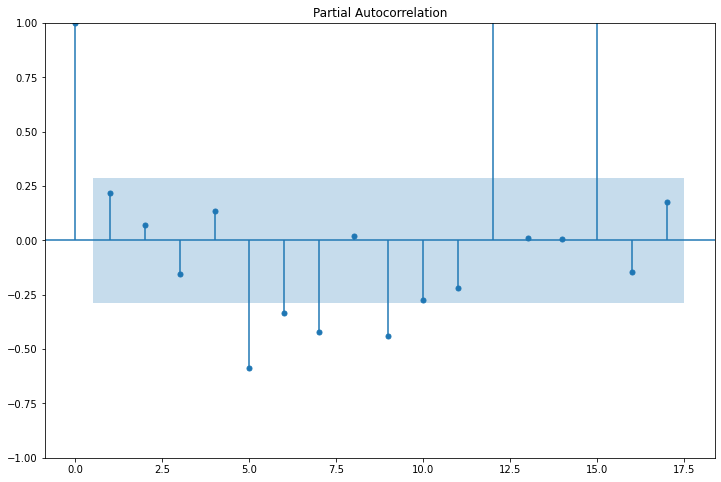

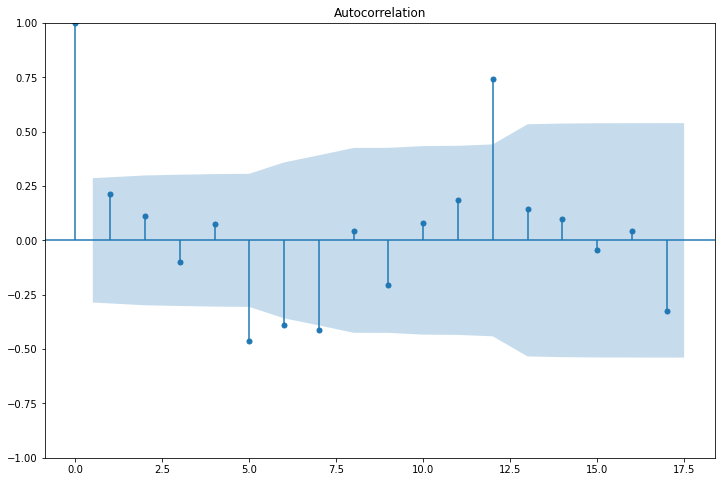

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt

plot_pacf(diff_data) # AR(p) 값 확인가능
plot_acf(diff_data) # MA(q) 값 확인가능

plt.show()

### ARIMA 분석

In [110]:
train_set["price"].values

array([3794, 3863, 5190, 5783, 6298, 6739, 7107, 6492, 5693, 5497, 5958,
       4309, 4323, 4391, 5860, 6552, 7370, 7888, 8330, 7401, 6599, 6411,
       6742, 4910, 4626, 4633, 6121, 7060, 7758, 7992, 8838, 7770, 7011,
       6644, 7102, 4952, 5008, 5160, 6624, 7697, 8240, 8851, 9758, 8176,
       7467, 7231, 7334, 5678], dtype=int64)

In [111]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

model = ARIMA(train_set["price"].values, order = (2,1,2))

res = model.fit()
res.summary()

C:\Users\gg787\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\gg787\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\gg787\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Mon, 25 Apr 2022   AIC                            761.750
Time:                        16:41:06   BIC                            771.001
Sample:                             0   HQIC                           765.231
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3168      0.190     -6.943      0.000      -1.689      -0.945
ar.L2         -0.3192      0.190     -1.676      0.094      -0.692       0.054
ma.L1          1.9700      0.242      8.124      0.000       1.495       2.445
ma.L2          0.9949      0.241      4.127      0.000       0.522       1.467
sigma2      4.451e+05   1.13e-06   3.93e+11      0.000    4.45e+05    4.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.83e+26. Standard errors may be unstable.
"""

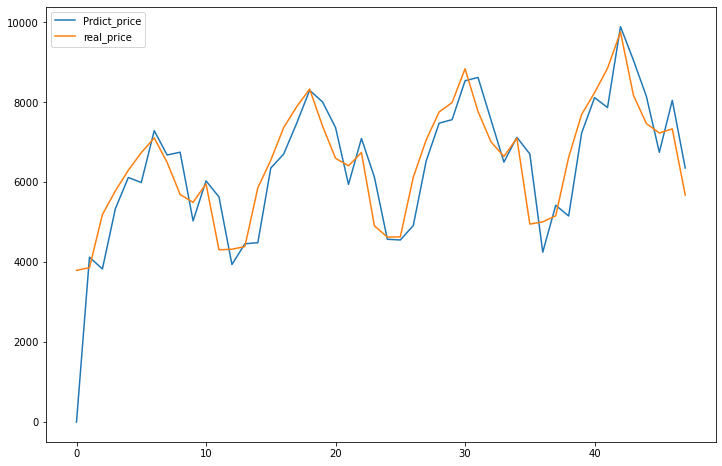

In [112]:
plt.plot(res.predict(), label = "Prdict_price")
plt.plot(train_set["price"].values, label = "real_price") 
plt.legend()

In [113]:
forecast_data = res.forecast(steps = len(test_set), alpha = 0.1)

pred_y = forecast_data.tolist()
pred_y

[5830.679304940258,
 5508.495326040213,
 5884.01349402863,
 5492.364579940843,
 5888.232140730608,
 5491.957799627773,
 5887.421364293514,
 5493.155245704233,
 5886.103351427435,
 5494.508610078836,
 5884.741916673472,
 5495.869389040086]

In [114]:
test_y = test_set.values

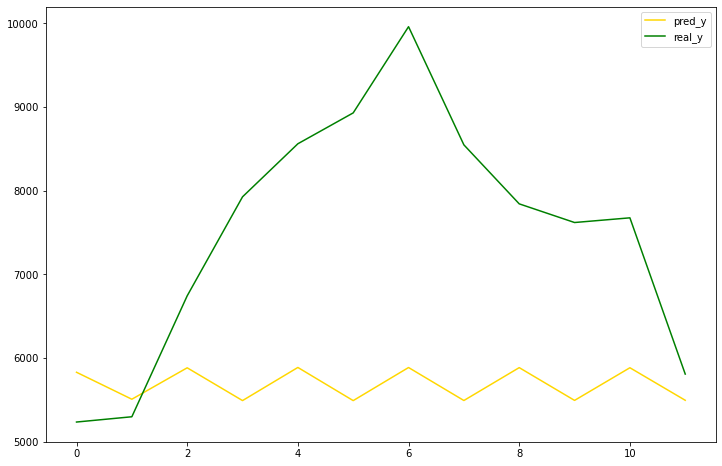

In [115]:
plt.plot(pred_y, color = "gold", label = "pred_y")
plt.plot(test_y, color = "green", label = "real_y")
plt.legend()

In [116]:
# 이경우는 arima 모델이 잘 맞지 않음
# 이 데이터는 추세와 계절성을 가지고 있는데 arima모델은 계절성을 반영하지 못하기 때문이다
# ARIMA 모델이 잘 맞는 경우는 계절성이 없는 경우이다

In [117]:
from sklearn.metrics import r2_score

R2_score = r2_score(test_y, pred_y)
print(R2_score)

-1.6428446451943275


In [118]:
regid = pred_y - test_y

In [119]:
import numpy as np

rmse = np.sqrt(np.sum(regid**2)/len(regid))

print(rmse)

8032.8570014710585


## SARIMA 실습

SARIMA :데이터가 지닌 계절성(주기에 따라 유사한 양상으로 변화하는 모양)까지 고려한 ARIMA 모델

In [120]:
import pandas as pd
import numpy as np
df = pd.read_csv("arima_data.csv", names = ["day","price"])

In [121]:
df.set_index("day", inplace = True)

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [123]:
df_train_len = int(df.shape[0]*0.8)
df_train = df[:df_train_len]
df_test = df.drop(df_train.index, axis = 0)

In [124]:
# 정상성 검정
from statsmodels.tsa.stattools import adfuller

adf = adfuller(df_train, regression = "ct") #상수항을 갖는다는건 시계열 변수의 평균값이 0이 아닌지

print("ADF -statistic :", adf[0])
print("P_value:", adf[1])

ADF -statistic : -1.9997199341327108
P_value: 0.6015863303794554


<AxesSubplot:xlabel='day'>

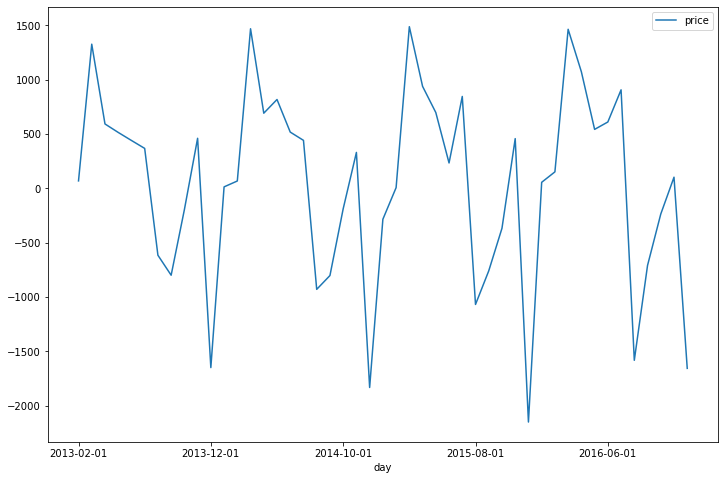

In [125]:
# 정상성을 만족시키기 위해 차분

diff_data = df_train.diff(1)
diff_data = diff_data.dropna()

diff_data.plot()

In [126]:
model = SARIMAX(df_train["price"].values, order = (2,1,2), seasonal_order= (1,1,1,12),\
               trend = "ct", enforce_invertibility= False) #, = False 없애야 밑ㅠㅠ에께 작동됨

results = model.fit() 
results.summary()

C:\Users\gg787\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\gg787\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -236.869
Date:                              Mon, 25 Apr 2022   AIC                            491.739
Time:                                      16:41:07   BIC                            505.737
Sample:                                           0   HQIC                           496.571
                                               - 48                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -174.5807   1021.826     -0.171      0.864   -2177.322    1828.161
drift          4.4559     27.780      0.160      0.873     -49.992      58.904
ar.L1         -1.0773      0.383     -2.812      0.005      -1.828      -0.326
ar.L2         -0.9421      0.499     -1.888      0.059      -1.920       0.036
ma.L1          0.9221      0.625      1.476      0.140      -0.303       2.147
ma.L2          0.9130      0.872      1.047      0.295      -0.796       2.622
ar.S.L12      -0.8517      2.461     -0.346      0.729      -5.675       3.972
ma.S.L12       0.6669      3.239      0.206      0.837      -5.682       7.015
sigma2      4.507e+04   3.58e+04      1.258      0.208   -2.51e+04    1.15e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.56   Prob(JB):                         0.56
Heteroskedasticity (H):               1.04   Skew:                            -0.20
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

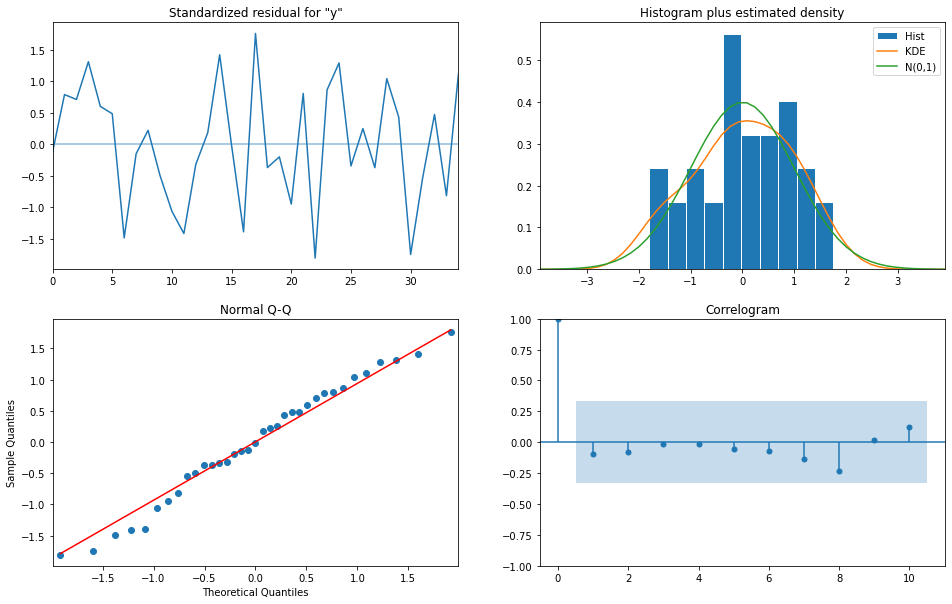

In [127]:
results.plot_diagnostics(figsize = (16,10))
plt.show()

### 예측값, mse, 신뢰구간의 최소 & 최대값

In [128]:
forecast_values = results.get_forecast(steps = len(df_test))
forecast_values.summary_frame()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,5527.499745,214.562224,5106.965514,5948.033976
1,5582.502876,280.138453,5033.441598,6131.564154
2,7233.627251,349.791412,6548.048681,7919.205820
3,8195.873988,407.563574,7397.064062,8994.683915
4,8703.778856,446.285375,7829.075594,9578.482118
5,9362.258183,493.890356,8394.250873,10330.265493
6,10191.469287,534.864376,9143.154374,11239.784201
7,8741.796437,565.637379,7633.167546,9850.425327
8,8172.550781,604.355161,6988.036432,9357.065130
9,7769.740545,637.178999,6520.892655,9018.588436


In [129]:
forecast_values.conf_int()

array([[ 5106.96551412,  5948.03397575],
       [ 5033.44159759,  6131.56415436],
       [ 6548.04868075,  7919.20582032],
       [ 7397.06406186,  8994.68391473],
       [ 7829.07559444,  9578.48211796],
       [ 8394.25087289, 10330.26549285],
       [ 9143.15437377, 11239.78420068],
       [ 7633.16754621,  9850.42532698],
       [ 6988.03643195,  9357.06513014],
       [ 6520.89265507,  9018.58843582],
       [ 6723.66931664,  9326.18825841],
       [ 4994.37900344,  7728.01243377]])

## 예측값을 그리는 함수

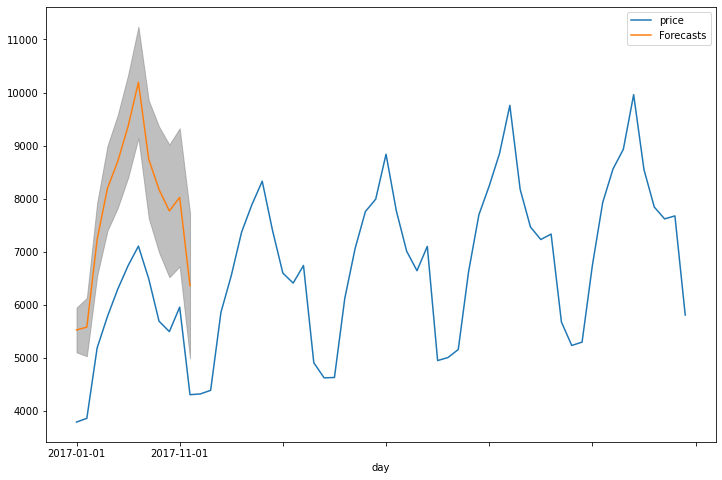

In [130]:
ax = df.plot()
pred_ci = pd.DataFrame(forecast_values.conf_int())
pred_ci.index = list(df_test.index)

#https://seong6496.tistory.com/113 fill_between
ax.fill_between(pred_ci.index,\
                pred_ci.iloc[:,0],\
                pred_ci.iloc[:,1], color = "gray", alpha = 0.5)

predicted = pd.DataFrame(forecast_values.predicted_mean)
predicted.index = list(df_test.index)
predicted.columns = ['Forecasts']
predicted.plot(ax=ax, label="Forecasts")


plt.legend()
plt.show()

In [131]:
from sklearn.metrics import r2_score
r2_score(predicted, df_test)

0.9411989273514944